In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import dice_ml


In [19]:
def load_and_clean_data():
    """Charge et nettoie les données de maladies cardiaques."""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
    columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
               'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
    df = pd.read_csv(url, header=None, names=columns)
    df.replace('?', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    categorical_mapping = {
        'sex': {0: 'femme', 1: 'homme'},
        'cp': {1: 'angine typique', 2: 'angine atypique',
               3: 'douleur non-angineuse', 4: 'asymptomatique'},
        'fbs': {0: 'normal', 1: 'élevé'},
        'restecg': {0: 'normal', 1: 'anomalie ST-T', 2: 'hypertrophie VG'},
        'exang': {0: 'non', 1: 'oui'},
        'slope': {1: 'ascendant', 2: 'plat', 3: 'descendant'},
        'thal': {3: 'normal', 6: 'défaut fixe', 7: 'défaut réversible'}
    }

    for col, mapping in categorical_mapping.items():
        df[col] = df[col].map(mapping)
    df['target'] = df['target'].apply(lambda x: 'Maladie' if x > 0 else 'Pas de Maladie')

    return df

In [20]:
def build_model(X_train, y_train):
    """Construit et entraîne un modèle 'Random Forest'"""
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
    numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
    pipeline_rf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', rf_model)
    ])

    return pipeline_rf.fit(X_train, y_train)

In [21]:
def evaluate_model(model, X_test, y_test):
    """Évalue le modèle et affiche les métriques de classification."""
    y_pred = model.predict(X_test)

    print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {metrics.precision_score(y_test, y_pred, pos_label='Maladie'):.3f}")
    print(f"Recall: {metrics.recall_score(y_test, y_pred, pos_label='Maladie'):.3f}")
    print(f"F1-score: {metrics.f1_score(y_test, y_pred, pos_label='Maladie'):.3f}")

    plt.figure(figsize=(6, 5))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pas de Maladie', 'Maladie'],
                yticklabels=['Pas de Maladie', 'Maladie'])
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Réelle')
    plt.show()


In [22]:
def generate_counterfactuals(model, X, y):
    """Génère des explications contrefactuelles avec DiCE."""
    numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

    data_for_dice = pd.concat([X, pd.Series(y, name='target')], axis=1)
    d = dice_ml.Data(dataframe=data_for_dice,
                     continuous_features=numerical_features,
                     outcome_name='target')

    m = dice_ml.Model(model=model, backend='sklearn')
    exp = dice_ml.Dice(d, m, method='random')

    features_to_vary = ['age', 'trestbps', 'chol', 'thalach', 'cp', 'exang', 'oldpeak', 'slope']
    patient_index = 0
    dice_exp = exp.generate_counterfactuals(
        X.iloc[patient_index:patient_index+1],
        total_CFs=2,
        desired_class='opposite',
        features_to_vary=features_to_vary
    )

    print(dice_exp.visualize_as_dataframe(show_only_changes=True))


Accuracy: 0.811
Precision: 0.821
Recall: 0.762
F1-score: 0.790


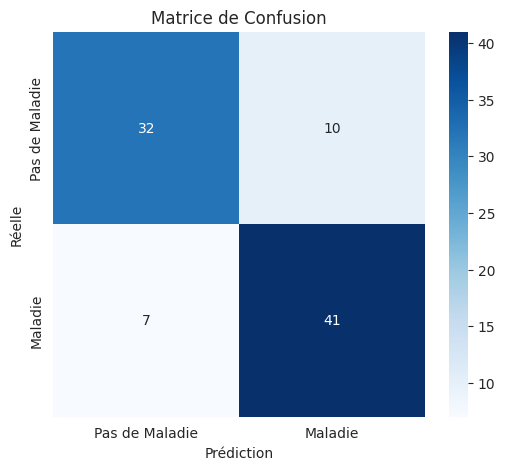

100%|██████████| 1/1 [00:00<00:00, 11.39it/s]

Query instance (original outcome : Pas de Maladie)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,homme,angine typique,145.0,233.0,élevé,hypertrophie VG,150.0,non,2.3,descendant,0.0,défaut fixe,Pas de Maladie



Diverse Counterfactual set (new outcome: Maladie)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-,-,-,-,-,-,-,82.9,-,-,plat,-,-,Maladie
1,-,-,-,-,326.1,-,-,-,-,-,plat,-,-,Maladie


None


In [23]:
# Exécution du script principal
df_heart = load_and_clean_data()
X = df_heart.drop('target', axis=1)
y = df_heart['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = build_model(X_train, y_train)
evaluate_model(model, X_test, y_test)
generate_counterfactuals(model, X, y)


e# **Analyse des Résultats**

## **1. Évaluation du Modèle**
### **Matrice de Confusion**
- Le modèle a correctement prédit :
  - 32 cas de "Pas de Maladie".
  - 41 cas de "Maladie".
- Les erreurs incluent :
  - 10 faux positifs (prédit comme "Maladie" mais réellement "Pas de Maladie").
  - 7 faux négatifs (prédit comme "Pas de Maladie" mais réellement "Maladie").
- Ces résultats montrent un bon équilibre entre la sensibilité (rappel) et la précision.

### **Métriques de Performance**
- **Précision (Precision)** : 82.1 %, indiquant que parmi les prédictions positives, 82.1 % étaient correctes.
- **Rappel (Recall)** : 76.2 %, montrant que le modèle a capturé 76.2 % des cas réels de "Maladie".
- **F1-Score** : 79.0 %, une mesure harmonique qui équilibre la précision et le rappel, confirmant la performance globale solide.
- **Exactitude (Accuracy)** : 81.1 %, une mesure générale de la performance du modèle.

---

## **2. Instance Query et Explications Contrefactuelles**
### **Instance Query**
- L'instance analysée initialement correspond à un patient de 63 ans, identifié comme "Pas de Maladie" par le modèle, avec les caractéristiques suivantes :
  - **Cholestérol total** : 233 mg/dL (niveau élevé).
  - **Fréquence cardiaque maximale (thalach)** : 150 bpm (normale).
  - **Dépression du segment ST (Oldpeak)** : 2.3 (indicateur de stress cardiaque).
  - **Sexe** : Homme.

### **Explications Contrefactuelles**
- Deux scénarios alternatifs ont été générés pour que ce patient soit classifié comme "Maladie" :
  - **Scénario 1** :
    - Une modification similaire de la slope (plat) combinée à une augmentation de la variable 'thalach' (max heart rate) a également conduit à un diagnostic de "Maladie".
  - **Scénario 2** :
    - Le cholestérol devait augmenter à **326.1**.
    - La pente du segment ST devait passer à **plat**, indiquant une anomalie dans l'électrocardiogramme.

---

## **3. Interprétation Médicale**
### **Facteurs Déterminants**
- Une augmentation significative du **cholestérol** est un facteur clé dans la classification en "Maladie", reflétant son importance comme facteur de risque.
- La pente du segment ST (**plat**) joue également un rôle critique dans le diagnostic de la maladie.

### **Prise de Décision Clinique**
- Ces explications soulignent des variables **modifiables** (comme le cholestérol) pouvant être ciblées par des interventions médicales ou des changements de mode de vie.
- Les résultats pourraient aider les cliniciens à identifier des patients à risque avant que des complications graves ne surviennent.

---

## **4. Limitations et Améliorations**
### **Limites des Contrefactuels**
- Les scénarios contrefactuels générés ne prennent pas toujours en compte les **contraintes biologiques ou médicales réalistes** (par exemple, des niveaux de cholestérol très élevés).
- Ajouter des **contraintes sur les variables** permettrait de générer des explications médicalement plausibles.

### **Améliorations du Modèle**
- Intégrer des données supplémentaires (par exemple, marqueurs inflammatoires, antécédents familiaux) pourrait améliorer les prédictions.
- Tester d'autres modèles comme les réseaux neuronaux ou des méthodes d'ensemble (par exemple, XGBoost) pour comparer les performances.

---

## **5. Conclusion**
Le modèle Random Forest a bien performé avec une précision globale de **81.1 %** et une capacité à capturer les cas réels de maladies cardiaques avec un rappel de **76.2 %**.
Les explications contrefactuelles générées à l'aide de DiCE offrent des perspectives intéressantes pour comprendre les facteurs de risque clés et guider les décisions médicales.
Cependant, il est essentiel de s'assurer que ces scénarios restent **réalistes et exploitables** pour leur utilisation pratique.
